# **Path Loading**

In [ ]:
!pwd

In [ ]:
mv /content/drive/MyDrive/data mdata

In [ ]:
mv /content/drive/MyDrive/model_checkpoints mdata

# **Installing and Importing Dependencies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#opencv is used to preprocess our data
#matplotlib is used for creating high-quality visualizations and graphs.
#imageio provides an easy interface to read and write a wide range of image data, including animated images, video
#gdown proviodes an ability to download publicly available files and folders from Google Drive.
#tensorflow is used for building model
!pip install opencv-python matplotlib imageio gdown tensorflow

**Importing Dependencies**

In [ ]:
#For traversing through different file systems:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#For using type annotations for documenting the code
from typing import List
import imageio

**To prevent exponential memory growth**

In [ ]:
physical_devices=tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
  pass

#  **Data Preprocessing**

In [ ]:
#Dataset : We will be using some part of The Grid Audio-Visual Speech Corpus to build our model
#The actual grid dataset has 34 speakers, but for simplicity we'll break down to one speaker
#This dataset is avaialble on gdrive, for accessing it we are using gdown
#The google drive link is https://drive.google.com/file/d/1Nyy_8OND_EgvUJQPfbqEAH1CVfkwDOtg/view?usp=share_link
# import gdown
# link='https://drive.google.com/file/d/1Nyy_8OND_EgvUJQPfbqEAH1CVfkwDOtg/view?usp=share_link'
# output='data.zip'
# gdown.download(link,output,quiet=False)
# # gdown.extractall('data.zip')
#We're encountering that the downloaded file is not a zip file, so I manually downlaoded the data and uploaded in env
#we'll load data manually the data is available in google drive

In [ ]:
#Writing a function to load the video
def load_video(path:str)->List[float]:
  #we'll first create a video capture instance
  video_capture=cv2.VideoCapture(path)
  #we'll loop through each one of the frames and store it an array called frames
  frames=[]
  for _ in range(int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))):
    #read the frame
    ret, frame=video_capture.read()
    #convert the frame to grayscale by using tensorflow
    frame=tf.image.rgb_to_grayscale(frame)
    #isolate the mouth region
    frames.append(frame[190:236,80:220,:])
    #But, the original Lipnet paper actually uses an advanced technique to detect the mouth using DLIB
  #release the video capture instance
  video_capture.release()

  #standardise the data using mean,SD
  mean=tf.math.reduce_mean(frames)
  std=tf.math.reduce_std(tf.cast(frames,tf.float32))
  return tf.cast((frames - mean), tf.float32)/std

In [ ]:
#Create a list of alphabets and numbers that may encounter in annotations/alignments
alphanum=[x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
alphanum

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
#we'll use keras stringlookup to convert char->num and vice cersa
char_to_num=tf.keras.layers.StringLookup(vocabulary=alphanum,oov_token="")
#oov_token="" will place "" if it encounters the caracter which isn't seen beofre
num_to_char=tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),oov_token="",invert=True
    )
#print our vocabulary and its size
print(char_to_num.get_vocabulary())
print(char_to_num.vocabulary_size())

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
40


In [ ]:
#create a fucntion to load alingments
def load_alignments(path:str)->List[str]:
  with open(path, 'r') as f:
    lines=f.readlines()
  #create an array tokens to store the numeric val of alinments by using char_to_num
  tokens=[]
  for line in lines:
    #split each one of lines in alignments
    line=line.split()
    #ignore if the alignment has character 'sil'
    if line[2]!='sil':
      #append in tokens
      tokens=[*tokens,'',line[2]]
  #return numeric val of tokens
  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
#Now we'll create a fucntion to load the data - both video and alignments simultaneously and returns the preprocessed video and alignments
def load_data(path:str):
  path=bytes.decode(path.numpy())
  #splits the filename for
  file_name=path.split('/')[-1].split('.')[0]
  #create sep paths for both align and video
  #appending file_name to get video
  video_path=os.path.join('data','s1',f'{file_name}.mpg')
  #appending file_name to get alignment
  #remember alignment and video file names are same, check dataset
  align_path=os.path.join('data','alignments','s1',f'{file_name}.align')
  frames=load_video(video_path)
  alignments=load_alignments(align_path)
  return frames,alignments


In [ ]:
#Let's check for some test video
test_path='/content/data/s1/bbaf3s.mpg'
#This is how splitting goes
tf.convert_to_tensor(test_path)

<tf.Tensor: shape=(), dtype=string, numpy=b'/content/data/s1/bbaf3s.mpg'>

In [ ]:
#Now we'll pass this test path in load_data to return preprocessed video and alingments
frames,alignments=load_data(tf.convert_to_tensor(test_path))
#we'll use them in our NN

In [ ]:
#let's load the frames shape
frames.shape
#75 frames in lenghth, with each of shape 46*140*1

TensorShape([75, 46, 140, 1])

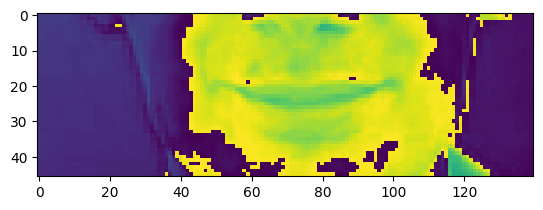

In [ ]:
#lets plot one frame
plt.imshow(frames[74])
#using mean and sd will be able to isolate these regions yellow

In [ ]:
#lets look aligments
alignments

<tf.Tensor: shape=(18,), dtype=int64, numpy=
array([ 9, 14,  2, 12, 21,  5,  1, 20,  6, 20,  8, 18,  5,  5, 19, 15, 15,
       14])>

In [ ]:
#lets see the characters
num_to_char(alignments).numpy()

array([b'i', b'n', b'b', b'l', b'u', b'e', b'a', b't', b'f', b't', b'h',
       b'r', b'e', b'e', b's', b'o', b'o', b'n'], dtype=object)

In [ ]:
#lets decode them
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'inblueatfthreesoon'>

In [ ]:
#Now let's create a mappable function for string processing which will be used in datapipelines
def mappable_function(path:str)->List[str]:
  res=tf.py_function(load_data,[path],[tf.float32,tf.int64])
  return res

# **Data Pipelines to NN**

In [ ]:
#Through datapipeline, tf will be used train the model by drawing random samples from data to complete one training step
data=tf.data.Dataset.list_files('data/s*/*.mpg')
#shuffle first 500 and return any one out of them
data=data.shuffle(500,reshuffle_each_iteration=False)
#use mappable function to create two vid and align paths for selected path
data=data.map(mappable_function)


In [ ]:
frames,alignments=data.as_numpy_iterator().next()
alignments
#every time the length of aligmnets will be different, so lets padd them to a specific length

array([12,  1,  3,  5,  7, 18,  5,  5, 14,  1, 20,  5, 26,  5, 18, 15, 16,
       12,  5,  1, 19,  5])

In [ ]:
#create a batch of 2 videos and 2 alignments
#no padding in video, make len of alignment to 40, if less than 40 values are 0
data=data.padded_batch(2,padded_shapes=([75,None,None,None],[40]))
#optimize our datapipeline
data=data.prefetch(tf.data.AUTOTUNE)
#splitting data
train=data.take(450)
test=data.skip(450)

In [ ]:
frames,alignments=data.as_numpy_iterator().next()
len(alignments)

2

In [ ]:
#take a test data from data
test_data=data.as_numpy_iterator()
val=test_data.next()
#get frames
val[0][0].shape

(75, 46, 140, 1)

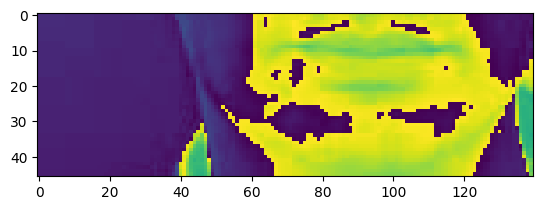

In [ ]:
plt.imshow(val[0][0][0])#in videos batch - first video - first frame

In [ ]:
#Check aligments too
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'ayredbyeeightplease'>

In [ ]:
#convert the array to gif
!pip install imageio==2.23.0
imageio.mimsave('/content/test.gif',val[0][0],fps=10) #takes 2 video instance of the bacth
#we'll pass this through out neural network

# **Design NN**

In [ ]:
#we'll use 3D conv layers to pass videos and condense it down to a classification dense layer which predicts char
#we'll use a special loss func called CTC loss func
#we'll use this loss func when we don't have word transriptions that aren't aligned to frames - it reduces the dupicates
from keras.models import Sequential
from keras.layers import Conv3D,Dense,LSTM,MaxPool3D,Flatten,Dropout,Bidirectional,Activation,Reshape,SpatialDropout3D,TimeDistributed,Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,LearningRateScheduler

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))
#lstm layer 1 , orthogonal initializer as Lipnet paper uses this
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))
#lstm layer 2
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))
# The Conv3D layers extract spatial features, while the Bidirectional LSTM layers capture temporal dependencies in the sequence data.

In [ ]:
model.summary()
#o/p will be 75,41 - 75 frames and 41 o/ps which are one hot encoded representation of our char

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

In [ ]:
#let's predict for sample i/p
samppred=model.predict(val[0])

1/1 [==============================] - 22s 22s/step


In [ ]:
#let's decodde what our model is predicting
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in samppred[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'xxxxyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy999yffffffffffffffffffffffffffffffff'>

In [ ]:
# Define the directory and file names
#code for h5 conversion
checkpoint_dir = '/content/mcheckpoints/checkpoints'  # Update this path
checkpoint_prefix = 'checkpoint'

# Load the model architecture (replace this with your actual model architecture)


# Load the checkpoint
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)).expect_partial()

# Save the model as .h5
model.save('model.h5')

print("Model saved as model.h5")


# **Start Training**

In [ ]:
#define a learning rate scheduler
def scheduler(epoch,lr):
  if epoch<30:
    return lr
  else:#drop the lr exponentiatlly
    return lr*tf.math.exp(-0.1)


In [ ]:
#define loss func - CTC
def CTCLoss(y_true,y_pred):
  batch_len=tf.cast(tf.shape(y_true)[0],dtype='int64')
  input_length=tf.cast(tf.shape(y_pred)[1],dtype='int64')
  label_length=tf.cast(tf.shape(y_true)[1],dtype='int64')
  input_length=input_length*tf.ones(shape=(batch_len,1),dtype='int64')
  label_length=label_length*tf.ones(shape=(batch_len,1),dtype='int64')
  loss=tf.keras.backend.ctc_batch_cost(y_true,y_pred,input_length,label_length)
  #y_true-will be our align
  #y_pred-will be one hot encoded pred
  #input_length-will be 75
  #label_length-will be 40
  return loss

In [ ]:
#define a custom Keras callback class
class ProduceExample(tf.keras.callbacks.Callback):
  def __init__(self,dataset)->None:
    #the callback is initialized with a dataset argument.
    self.dataset=dataset.as_numpy_iterator()
  #callback method that gets called at the end of each epoch
  #epoch represents the current epoch number and logs contains the training metrics from the current epoch.
  def on_epoch_end(self,epoch,logs=None)-> None:
    #next() to get the next batch of data
    data=self.dataset.next()
    #self.model predicts the output based on the input data (data[0]). The predictions are stored in the yhat variable.
    yhat=self.model.predict(data[0])
    #greedy=False argument indicates that beam search decoding should be used instead of greedy decoding
    decoded=tf.keras.backend.ctc_decode(yhat,[75,75],greedy=False)[0][0].numpy()
    for x in range(len(yhat)):
       print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
       print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
       #a line of ~ characters is printed to visually separate each prediction and its corresponding original label
       print('~'*100)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
#Define callbacks
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test) #to check how our model is predicting at each epoch

In [ ]:
# #fit the model
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])


# **Start Testing**

In [ ]:
#load the checkpoint
model.load_weights('model_checkpoints/checkpoints/checkpoint')

In [ ]:
test_data=test.as_numpy_iterator()

In [ ]:
sampledata=test_data.next()

In [ ]:
sampledata

(array([[[[[ 1.182049  ],
           [ 1.182049  ],
           [ 0.72448164],
           ...,
           [ 0.38130614],
           [ 0.38130614],
           [ 0.38130614]],
 
          [[ 1.1439184 ],
           [ 1.1057878 ],
           [ 0.26691428],
           ...,
           [ 0.38130614],
           [ 0.38130614],
           [ 0.38130614]],
 
          [[ 1.4108326 ],
           [ 1.3727021 ],
           [ 1.0676571 ],
           ...,
           [ 0.38130614],
           [ 0.34317553],
           [ 0.34317553]],
 
          ...,
 
          [[ 1.2201797 ],
           [ 1.1439184 ],
           [ 1.1439184 ],
           ...,
           [ 0.07626123],
           [ 0.07626123],
           [ 0.07626123]],
 
          [[ 1.1439184 ],
           [ 1.1439184 ],
           [ 1.1439184 ],
           ...,
           [ 0.07626123],
           [ 0.07626123],
           [ 0.07626123]],
 
          [[ 1.1439184 ],
           [ 1.1439184 ],
           [ 1.1439184 ],
           ...,
           [ 0

In [ ]:
#lets predict by our model
yhat=model.predict(sampledata[0])

1/1 [==============================] - 14s 14s/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()


In [ ]:
#Let's see what our model has predicted
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set red at z zero please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set blue with b five again'>]

In [ ]:
#let's see what are the original predictions
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sampledata[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'etredatozeroplease'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'etbluewithbfiveagain'>]

test on a video manually

In [ ]:
vid=load_data(tf.convert_to_tensor('/content/data/s1/bbal7s.mpg'))

In [ ]:
yhat=model.predict(tf.expand_dims(vid[0],axis=0))

1/1 [==============================] - 5s 5s/step


In [ ]:
yhat

array([[[4.3409955e-07, 5.1527792e-07, 9.9908400e-01, ...,
         6.0157808e-09, 7.0081437e-06, 5.7435539e-08],
        [1.1556307e-06, 1.1040611e-05, 4.1287908e-04, ...,
         1.2609860e-10, 5.8621258e-06, 6.8504056e-07],
        [1.3382200e-06, 2.3209769e-04, 2.3204213e-06, ...,
         1.1135842e-11, 1.8604673e-05, 7.6225041e-07],
        ...,
        [9.9994302e-01, 4.1289730e-10, 1.4618448e-09, ...,
         6.7160032e-12, 7.6918445e-09, 5.6764275e-05],
        [6.3084510e-05, 4.1668741e-10, 4.8672788e-10, ...,
         1.3651224e-12, 2.3364921e-09, 9.9993658e-01],
        [9.9986279e-01, 3.1642553e-09, 8.6580423e-09, ...,
         9.5976907e-11, 7.2776899e-08, 1.3586233e-04]]], dtype=float32)

In [ ]:
#let's see what are the original predictions
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [vid[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'inblueatlsevensoon'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()


In [ ]:
#Let's see what our model has predicted
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l seven soon'>]